In [248]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [178]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import eigsh
from scipy.sparse.csgraph import connected_components
import scipy as sp

def compute_affinity(x, kernel="cosine", gamma=None, non_zeros=True):
    x = x.copy()
    if kernel in {'pearson', 'spearman'}:
        if kernel == 'spearman':
            x = sp.stats.rankdata(group_average, axis=1)
        affinity = np.corrcoef(x)
    elif kernel in {'cosine', 'normalized_angle'}:
        x = 1 - squareform( pdist(x, metric='cosine') )
        if kernel == 'normalized_angle':
            x = 1 - np.arccos(x, x)/np.pi
        affinity = x
    elif kernel == 'rbf':
        if gamma is None:
            gamma = 1 / x.shape[1]
        affinity = rbf_kernel(x, gamma=gamma)
    else:
        raise ValueError("Invalide kernel")
    if non_zeros:
        affinity[affinity<0] = 0
    
    n_connected_components = connected_components(affinity)[0]
    if n_connected_components != 1:
        raise ValueError(f"Invalide connected components {n_connected_components}")
    return affinity

def compute_diffusion_map(affinity, alpha=0.5, n_components=2, diffusion_time=0):
    D_alpha = np.diag( np.power(affinity.sum(axis=1), -alpha) )
    L_alpha = D_alpha.dot(affinity).dot(D_alpha)
    D_alpha = np.diag( L_alpha.sum(axis=1) )
    P = np.linalg.inv(D_alpha).dot(L_alpha)

    v0 = np.random.uniform(-1, 1, affinity.shape[0])
    eigen_vals, eigen_vecs = eigsh(P, k=n_components+1, which='LM', tol=0, v0=v0)
    eigen_vals, eigen_vecs = eigen_vals[::-1], eigen_vecs[:, ::-1] #从大到小

    eigen_vals = eigen_vals[1:]/eigen_vals[0]
    if diffusion_time <= 0:
        eigen_vals /= (1-eigen_vals)
    else:
        eigen_vals **= diffusion_time
    eigen_vecs = eigen_vecs[:, 1:]/eigen_vecs[:, [0]]

    eigen_vecs_rescale = eigen_vecs * eigen_vals[None, :]
    eigen_vecs_rescale *= np.sign(np.abs(eigen_vecs_rescale).max(axis=0))[None, :]
    return eigen_vecs_rescale, eigen_vals

In [232]:
group_average = np.load('./test/rsfMRI/group246_965_rfconnection.npy').mean(axis=0).reshape((246, 246))
anno_network = pd.read_table("./test/rsfMRI/BrainnetomeAtlasToYeoNetwork.tsv")
network_labels = ["None", "Visual", "Somatomotor", "Dorsal Attention", "Ventral Attention", "Limbic", "Frontoparietal", "Default"]

In [247]:
r = np.sort(np.corrcoef(group_average), axis=1)
r[:, :r.shape[1]//10] = 0
affinity = compute_affinity(r, kernel="normalized_angle")
fc_gredient, fc_vals = compute_diffusion_map(affinity, alpha=0.5, diffusion_time=0)
fc_gredient_mean = pd.DataFrame(fc_gredient[:, 0]).groupby(anno_network['Yeo_7network']).mean()
fc_gredient_mean

,0
Yeo_7network,
0,0.046089
1,0.068608
2,0.062610
3,0.042436
4,0.039752
5,-0.041471
6,-0.047493
7,-0.167553


In [255]:
pickle.dump([fc_gredient, fc_vals], open("./fc_gredient.pkl", "wb"))

In [256]:
fc_gredient, fc_vals = pickle.load(open("./fc_gredient.pkl", "rb"))
pd.DataFrame(fc_gredient[:, 0]).groupby(anno_network['Yeo_7network']).mean()

,0
Yeo_7network,
0,0.046089
1,0.068608
2,0.062610
3,0.042436
4,0.039752
5,-0.041471
6,-0.047493
7,-0.167553


In [265]:
data = []
for idx in range(8):
    data.append(fc_gredient[anno_network['Yeo_7network']==idx, 0])
len(data)
fc_gredient_mean = pd.DataFrame(fc_gredient[:, 0]).groupby(anno_network['Yeo_7network']).mean().values[:, 0]

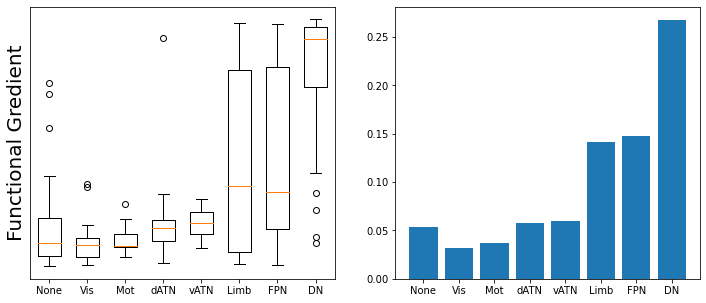

In [273]:
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
for i, dat in enumerate(data):
    ax.boxplot(-dat, positions=[i], widths=0.6)
ax.set_xticklabels(["None", "Vis", "Mot", "dATN", "vATN", "Limb", "FPN", "DN"])
ax.set_yticks([])
ax.set_ylabel("Functional Gredient", size=20)

plt.subplot(1, 2, 2)
plt.bar(["None", "Vis", "Mot", "dATN", "vATN", "Limb", "FPN", "DN"], -fc_gredient_mean+0.1)

plt.show()
plt.close()